# spark-dist-fit Quick Start

This notebook demonstrates how to use spark-dist-fit to fit statistical distributions to your data using Apache Spark.

## Setup

In [1]:
import numpy as np
from pyspark.sql import SparkSession

from spark_dist_fit import DistributionFitter, FitConfig, PlotConfig

# Create Spark session
spark = SparkSession.builder.appName("DistFitDemo").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/11 21:16:57 WARN Utils: Your hostname, MacBook-Pro-4.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.74 instead (on interface en0)
25/12/11 21:16:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/11 21:16:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/11 21:16:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Generate Sample Data

We'll create data from a known distribution (normal) to verify the fitting works correctly.

In [3]:
np.random.seed(42)
data = np.random.normal(loc=50, scale=10, size=100_000)

df = spark.createDataFrame([(float(x),) for x in data], ["value"])
df.show(5)

+------------------+
|             value|
+------------------+
| 54.96714153011233|
| 48.61735698828815|
| 56.47688538100692|
| 65.23029856408026|
|47.658466252766644|
+------------------+
only showing top 5 rows


Exception ignored in: <_io.BufferedWriter name=5>
Traceback (most recent call last):
  File "/Users/dustin/venv/lib/python3.13/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 200, in manager
BrokenPipeError: [Errno 32] Broken pipe


## Basic Usage

Fit distributions with default settings.

In [ ]:
fitter = DistributionFitter()
results = fitter.fit(df, column="value", max_distributions=25)

# Get best fit
best = results.best(n=1)[0]
print(f"Best distribution: {best.distribution}")
print(f"SSE: {best.sse:.6f}")
print(f"Parameters: {best.parameters}")

In [6]:
# Top 5 distributions
for i, result in enumerate(results.best(n=5), 1):
    print(f"{i}. {result.distribution:20s} SSE={result.sse:.6f}")

1. fatiguelife          SSE=0.000011
2. f                    SSE=0.000012
3. erlang               SSE=0.000014
4. crystalball          SSE=0.000015
5. exponnorm            SSE=0.000015


[Stage 23:==================================================>       (7 + 1) / 8]

## Configuration from HOCON String

The recommended way to configure spark-dist-fit is using HOCON configuration. In notebooks, you can define the config as a multi-line string.

In [7]:
# Define configuration as HOCON string
fit_config_str = """
bins = 100
use_rice_rule = false
support_at_zero = false

excluded_distributions = [
    levy_stable
    kappa4
    ncx2
    ksone
    ncf
    wald
    mielke
    exonpow
]

enable_sampling = true
sample_fraction = 0.5
max_sample_size = 500000

random_seed = 123
"""

# Load from string
fit_config = FitConfig.from_string(fit_config_str)

print(f"Bins: {fit_config.bins}")
print(f"Sampling enabled: {fit_config.enable_sampling}")
print(f"Sample fraction: {fit_config.sample_fraction}")
print(f"Excluded: {fit_config.excluded_distributions}")

Bins: 100
Sampling enabled: True
Sample fraction: 0.5
Excluded: ['levy_stable', 'kappa4', 'ncx2', 'ksone', 'ncf', 'wald', 'mielke', 'exonpow']


In [ ]:
# Use the config
fitter_custom = DistributionFitter(config=fit_config)
results_custom = fitter_custom.fit(df, column="value", max_distributions=35)

best_custom = results_custom.best(n=1)[0]
print(f"Best: {best_custom.distribution} (SSE={best_custom.sse:.6f})")

## Plot Configuration from String

(<Figure size 1400x800 with 1 Axes>,
 <Axes: title={'center': 'Best Fit Distribution\nfatiguelife(c=0.0214, loc=-422.6339, scale=472.7009)\nSSE: 0.000011, AIC: 74970.02, BIC: 74991.65'}, xlabel='Value', ylabel='Density'>)

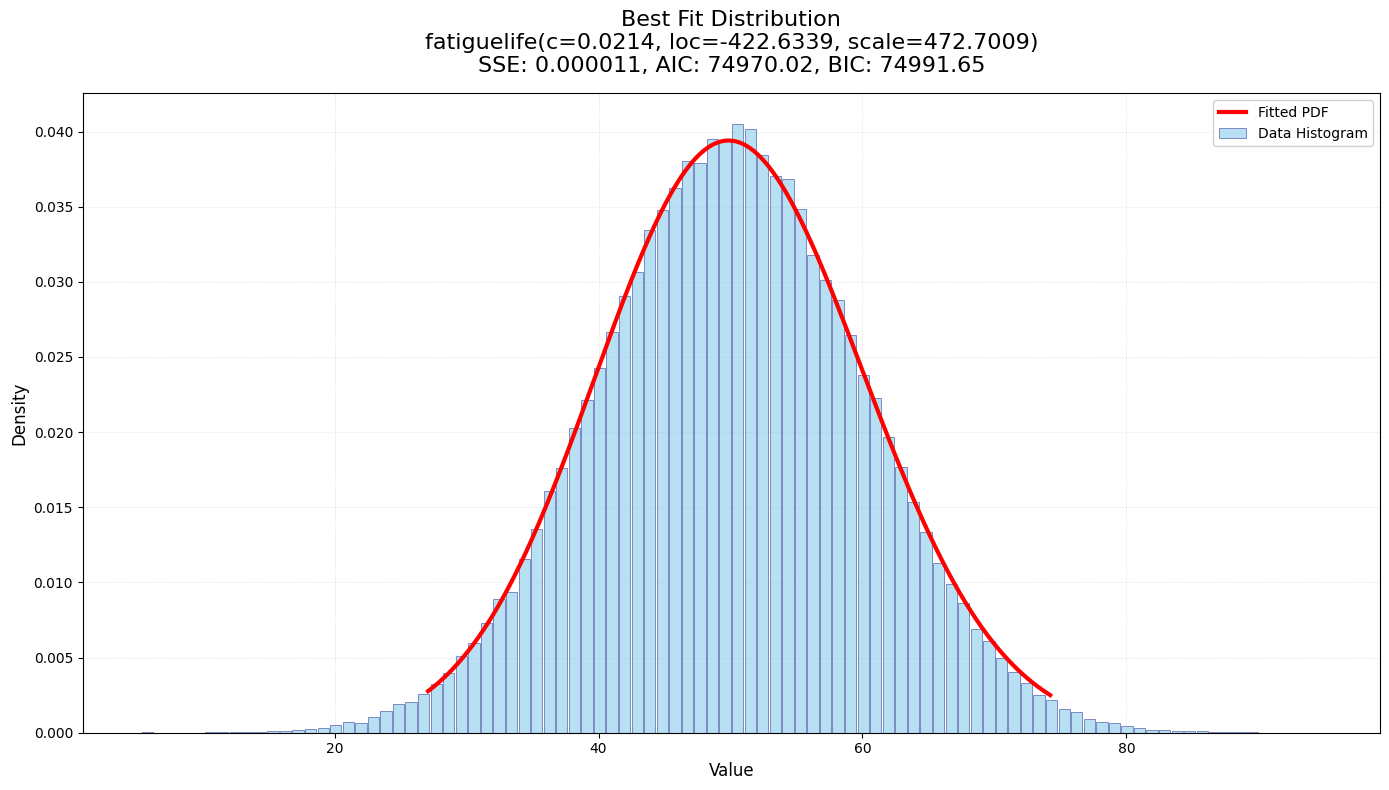

In [9]:
plot_config_str = """
figsize = [14, 8]
dpi = 100
show_histogram = true
histogram_alpha = 0.6
pdf_linewidth = 3
title_fontsize = 16
label_fontsize = 12
grid_alpha = 0.3
"""

plot_config = PlotConfig.from_string(plot_config_str)

fitter.plot(
    best,
    df,
    "value",
    config=plot_config,
    title="Best Fit Distribution",
    xlabel="Value",
    ylabel="Density"
)

## Non-Negative Data Example

When your data is strictly non-negative (e.g., prices, durations), use `support_at_zero = true` to only fit appropriate distributions.

In [ ]:
# Generate exponential data (non-negative)
data_exp = np.random.exponential(scale=5, size=100_000)
df_exp = spark.createDataFrame([(float(x),) for x in data_exp], ["value"])

# Config for non-negative distributions
non_neg_config = FitConfig.from_string("""
bins = 75
support_at_zero = true
enable_sampling = true
""")

fitter_exp = DistributionFitter(config=non_neg_config)
results_exp = fitter_exp.fit(df_exp, column="value", max_distributions=10)

print("Top 5 non-negative distributions:")
for i, result in enumerate(results_exp.best(n=5), 1):
    print(f"{i}. {result.distribution:20s} SSE={result.sse:.6f}")

## Using Fitted Distributions

Once you have a fitted distribution, you can use it to generate samples or evaluate PDF/CDF.

In [11]:
# Generate samples from the fitted distribution
samples = best.sample(size=10000, random_state=42)

print(f"Original data - mean: {data.mean():.2f}, std: {data.std():.2f}")
print(f"Fitted samples - mean: {samples.mean():.2f}, std: {samples.std():.2f}")

Original data - mean: 50.01, std: 10.01
Fitted samples - mean: 50.15, std: 10.16


In [12]:
# Evaluate PDF at specific points
x = np.array([30, 40, 50, 60, 70])
pdf_values = best.pdf(x)
cdf_values = best.cdf(x)

print("PDF and CDF values:")
for xi, pdf, cdf in zip(x, pdf_values, cdf_values):
    print(f"  x={xi}: PDF={pdf:.6f}, CDF={cdf:.4f}")

PDF and CDF values:
  x=30: PDF=0.005296, CDF=0.0214
  x=40: PDF=0.024297, CDF=0.1575
  x=50: PDF=0.039399, CDF=0.4974
  x=60: PDF=0.024089, CDF=0.8341
  x=70: PDF=0.005893, CDF=0.9731


[Stage 23:==================================================>       (7 + 1) / 8]

## Export Results

In [ ]:
# Convert all results to pandas DataFrame for further analysis
results_df = results.to_pandas()
results_df.head(10)

## Cleanup

In [ ]:
spark.stop()